In [1]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import torch
from unityagents import UnityEnvironment

from ddpg_agent import Agent

Trainin with GPU


In [2]:
env = UnityEnvironment(file_name='Reacher_20/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [4]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

In [5]:
def train(n_episodes=2000, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores_hist = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            rewards = [0.1 if rew > 0 else 0 for rew in rewards]
            dones = env_info.local_done 
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(done):
                break
        current_score = np.mean(scores)
        scores_deque.append(current_score)
        scores_hist.append(np.mean(scores_deque))
        print('\rEpisode {}\tScore : {:.2f}\tAverage Score: {:.2f}'.format(i_episode, current_score, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tScore : {:.2f}\tAverage Score: {:.2f}'.format(i_episode, current_score, np.mean(scores_deque)))
        
        if i_episode >= 100 and (np.mean(scores_deque)) >= 30.0:
            print("Enviroment Solved!")
            torch.save(agent.actor_local.state_dict(), 'best_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_critic.pth')
            break
    return scores_hist

Episode 10	Average Score: 6.82	Score: 10.69
Episode 20	Average Score: 11.93	Score: 19.31
Episode 30	Average Score: 16.70	Score: 25.88
Episode 40	Average Score: 22.23	Score: 45.63
Episode 50	Average Score: 27.51	Score: 50.96
Episode 60	Average Score: 33.65	Score: 79.15
Episode 70	Average Score: 41.69	Score: 97.54
Episode 80	Average Score: 48.55	Score: 93.75
Episode 90	Average Score: 53.99	Score: 98.53
Episode 100	Average Score: 58.40	Score: 98.59
Enviroment Solved!


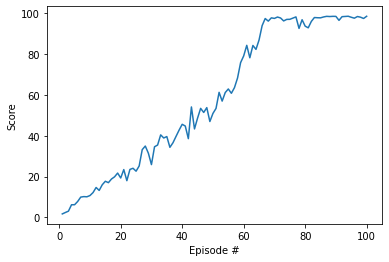

In [6]:
scores = train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()